<a href="https://colab.research.google.com/github/GiorgioMB/UniversityProjects/blob/main/FeatureMaps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from kaggle.api.kaggle_api_extended import KaggleApi
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Rescaling
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix,f1_score, recall_score, precision_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom

In [2]:
! pip install -q kaggle
from google.colab import files
files.upload()
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
os.environ['KAGGLE_CONFIG_DIR'] = '/kaggle.json'
dataset_name = 'puneet6060/intel-image-classification'
api = KaggleApi()
api.authenticate()
print("Authenticated, downloading dataset...")
api.dataset_download_files(dataset_name, path='/Users/micalettog/Desktop/Computer Science/Projects/BSDSA/ImageCNN/dataset/', unzip=True)
print("Dataset downloaded")

Authenticated, downloading dataset...
Dataset downloaded


In [5]:
batch_size = 32
img_height = 150
img_width = 150
num_classes = 6

dataset_test_dir = r"/Users/micalettog/Desktop/Computer Science/Projects/BSDSA/ImageCNN/dataset/seg_test/seg_test"
dataset_train_dir = r"/Users/micalettog/Desktop/Computer Science/Projects/BSDSA/ImageCNN/dataset/seg_train/seg_train"

train_ds = image_dataset_from_directory(
    dataset_train_dir,
    seed=341,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    dataset_test_dir,
    seed=341,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
val_true_labels = []  # List to store true labels

for images, labels in val_ds:
    val_true_labels.extend(labels.numpy())

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [6]:
data_augmentation = Sequential([
    RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    RandomRotation(0.1),
    RandomZoom(0.1),
    tf.keras.layers.GaussianNoise(0.2)
])

In [7]:
params = {'num_filters': 48, 'kernel_size': 4, 'learning_rate': 0.0007327937745194752, 'dropout': 0.06926692273600446, 'dropout2': 0.07112997036707623, 'dropout3': 0.0780814307539649, 'dropout4': 0.030436704275823536}

In [8]:
model = Sequential([
        data_augmentation,
        Rescaling(1./255),
        Conv2D(params['num_filters'], params['kernel_size'], activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(params['num_filters'], params['kernel_size'], activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(params['num_filters'], params['kernel_size'], activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(params['num_filters'], params['kernel_size'], activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        layers.GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(params['dropout']),
        Dense(128, activation='relu'),
        Dropout(params['dropout2']),
        Dense(64, activation='relu'),
        Dropout(params['dropout3']),
        Dense(32, activation='relu'),
        Dropout(params['dropout4']),
        Dense(16, activation='relu'),
        Dense(6, activation = 'softmax')
    ])
optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [11]:
history = model.fit(
    train_ds,
    epochs = 57,
    validation_data= val_ds,
    verbose = 2
)

Epoch 1/57
439/439 - 14s - loss: 0.2966 - accuracy: 0.8938 - val_loss: 0.5123 - val_accuracy: 0.8450 - 14s/epoch - 32ms/step
Epoch 2/57
439/439 - 11s - loss: 0.2963 - accuracy: 0.8935 - val_loss: 0.4651 - val_accuracy: 0.8513 - 11s/epoch - 24ms/step
Epoch 3/57
439/439 - 11s - loss: 0.3091 - accuracy: 0.8906 - val_loss: 0.4620 - val_accuracy: 0.8537 - 11s/epoch - 26ms/step
Epoch 4/57
439/439 - 9s - loss: 0.2972 - accuracy: 0.8928 - val_loss: 0.4743 - val_accuracy: 0.8450 - 9s/epoch - 21ms/step
Epoch 5/57
439/439 - 11s - loss: 0.2855 - accuracy: 0.8995 - val_loss: 0.4345 - val_accuracy: 0.8597 - 11s/epoch - 24ms/step
Epoch 6/57
439/439 - 11s - loss: 0.2924 - accuracy: 0.8955 - val_loss: 0.4830 - val_accuracy: 0.8423 - 11s/epoch - 24ms/step
Epoch 7/57
439/439 - 11s - loss: 0.2908 - accuracy: 0.8971 - val_loss: 0.5655 - val_accuracy: 0.8147 - 11s/epoch - 25ms/step
Epoch 8/57
439/439 - 9s - loss: 0.2901 - accuracy: 0.8953 - val_loss: 0.4721 - val_accuracy: 0.8480 - 9s/epoch - 21ms/step
Epoc

In [13]:
from tensorflow.keras.preprocessing import image
img_path = '5.jpg'
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img)
input_image = np.expand_dims(img_array, axis=0)

1/1 [==============================] - 0s 347ms/step


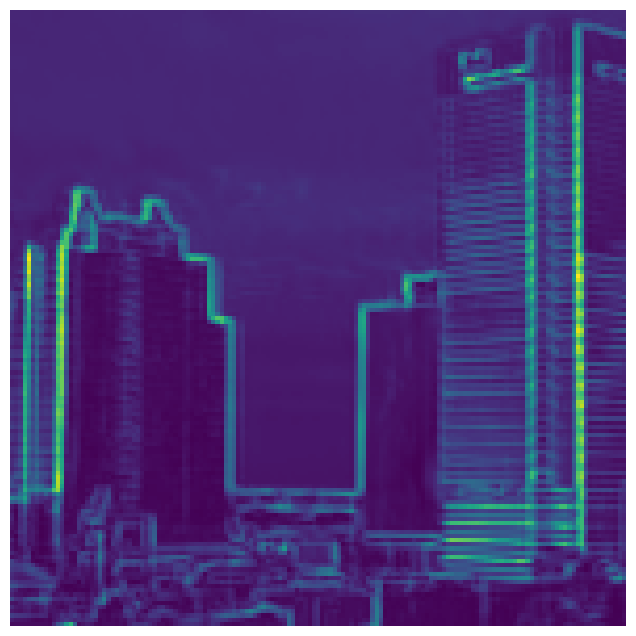

In [25]:
layer_outputs = [layer.output for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)]
feature_map_model = Model(inputs=model.input, outputs=layer_outputs)
feature_maps = feature_map_model.predict(input_image)

if not layer_outputs:
    raise ValueError("No Conv2D layers found in the model.")

feature_maps_last_layer = feature_maps[0]
num_feature_maps = feature_maps_last_layer.shape[-1]

aggregated_feature_map = np.mean(feature_maps_last_layer[0, :, :, :], axis=2)

# Visualizing the aggregated feature map
plt.figure(figsize=(8, 8))
plt.imshow(aggregated_feature_map, cmap='viridis')
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 76ms/step


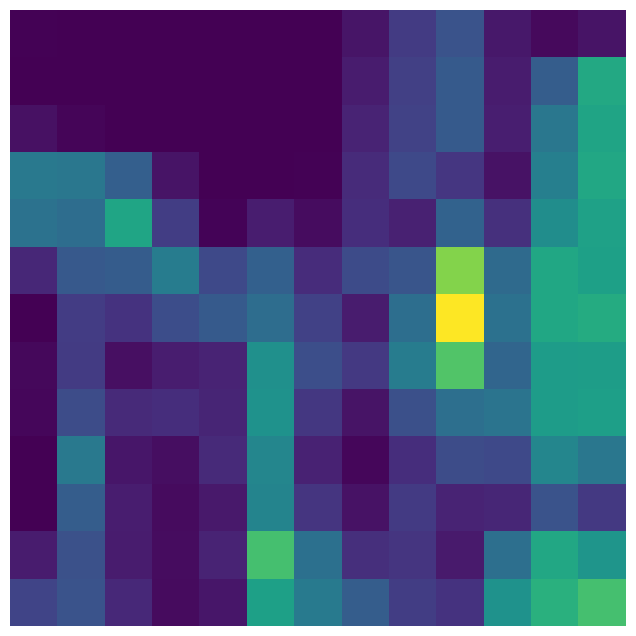

In [22]:
layer_outputs = [layer.output for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)]
feature_map_model = Model(inputs=model.input, outputs=layer_outputs)
feature_maps = feature_map_model.predict(input_image)

if not layer_outputs:
    raise ValueError("No Conv2D layers found in the model.")

feature_maps_last_layer = feature_maps[-1]
num_feature_maps = feature_maps_last_layer.shape[-1]

aggregated_feature_map = np.mean(feature_maps_last_layer[0, :, :, :], axis=2)

# Visualizing the aggregated feature map
plt.figure(figsize=(8, 8))
plt.imshow(aggregated_feature_map, cmap='viridis')
plt.axis('off')
plt.show()

In [24]:
predictions = model.predict(input_image)
predicted_class = np.argmax(predictions)
class_names = train_ds.class_names
predicted_class_name = class_names[predicted_class]
print(predicted_class_name)

1/1 [==============================] - 0s 27ms/step
buildings
